# ***Schizosaccharomyces pombe***

Trained models | Median molecules log transformed | ALL

In [1]:
import os
import time
import numpy as np
import pandas as pd
from joblib import dump, load

from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneOut
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, RobustScaler, Normalizer
from sklearn.pipeline import make_pipeline, make_union
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, ExtraTreesRegressor
from sklearn.linear_model import ElasticNetCV, SGDRegressor, RidgeCV, LassoLarsCV
from sklearn.svm import LinearSVR
from tpot.builtins import StackingEstimator
from xgboost import XGBRegressor

from sklearn.metrics import explained_variance_score, max_error, mean_absolute_error, mean_squared_error
from sklearn.metrics import mean_squared_log_error, median_absolute_error, r2_score, accuracy_score
from math import sqrt
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

/home/mauricio/Programas/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/home/mauricio/Programas/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html

## Loading trained model

In [2]:
filename = 'adaboost_ALL_2021-06-29.sav'
model = load(filename)

## Prediction of protein abundance

In [3]:
spombe = pd.read_csv("./pred_spombe.csv", sep='\t')

col_test = []
for column in spombe.columns:
    col_test.append(column)

test_known = col_test[2]
test_features = col_test[3:len(col_test)]

X_test = spombe[test_features].values
y_test = spombe[test_known].values
y_test = np.log1p(y_test)
y_test = np.reshape(y_test, (-1,1))

In [4]:
test_rescaled = y_test

predict_spombe = model.predict(X_test)
predict_spombe = np.reshape(predict_spombe, (-1,1))

/home/mauricio/Programas/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/base.py:158: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)
/home/mauricio/Programas/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/base.py:158: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your cur

In [5]:
baseline_preds_test = test_rescaled[:,test_known.index("Median molecules per cell")]
baseline_errors_test = abs(baseline_preds_test - test_rescaled)
errors_test = abs(predict_spombe - test_rescaled)
mape_test = 100 * (errors_test / test_rescaled)
accuracy_test = 100 - np.mean(mape_test)

print("Average baseline error: ", round(np.mean(baseline_errors_test),2))
print("Mean absolute error: ", round(np.mean(errors_test),2))
print("Accuracy: ", round(accuracy_test, 2), "%", "\n")

print("Explained variance regression score: ", explained_variance_score(test_rescaled, predict_spombe))
print("R2 score: ", r2_score(test_rescaled, predict_spombe))
print("Adjusted R2 score: ", 1 - (1-r2_score(test_rescaled, predict_spombe))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1), "\n")

print("Maximum residual error: ", max_error(test_rescaled, predict_spombe))
print("Median absolute error: ", median_absolute_error(test_rescaled, predict_spombe))
print("Mean absolute error: ", mean_absolute_error(test_rescaled, predict_spombe))
print("Mean squared error: ", mean_squared_error(test_rescaled, predict_spombe))
print("Root mean squared error:", sqrt(mean_squared_error(test_rescaled, predict_spombe)))
print("Mean squared logarithmic error: ", mean_squared_log_error(test_rescaled, predict_spombe))

Average baseline error:  1.79
Mean absolute error:  0.97
Accuracy:  88.1 % 

Explained variance regression score:  0.4491765337679756
R2 score:  0.4290538439113135
Adjusted R2 score:  0.4112179015137609 

Maximum residual error:  4.452178420322356
Median absolute error:  0.8171597823494441
Mean absolute error:  0.9650582261851481
Mean squared error:  1.450237804935225
Root mean squared error: 1.2042581969557962
Mean squared logarithmic error:  0.017404536463591837


In [6]:
pearson = stats.pearsonr(test_rescaled.ravel(), predict_spombe.ravel())
spearman = stats.spearmanr(test_rescaled.ravel(), predict_spombe.ravel())

print('Pearson\'s r:', pearson[0], 'p-value:', pearson[1])
print('Spearman\'s r:', spearman[0], 'p-value:', spearman[1])

Pearson's r: 0.7306753816162582 p-value: 0.0
Spearman's r: 0.7026983656906101 p-value: 0.0


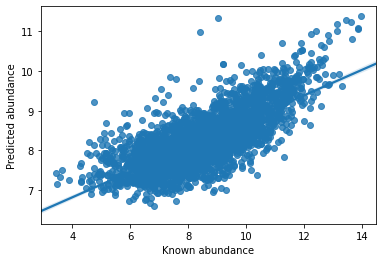

In [7]:
plot_data = pd.DataFrame()
plot_data['Known abundance'] = test_rescaled.ravel()
plot_data['Predicted abundance'] = predict_spombe.ravel()

sns.regplot(x='Known abundance', y='Predicted abundance', data=plot_data)

plt.savefig('figure07_3.svg', format='svg', dpi=600)

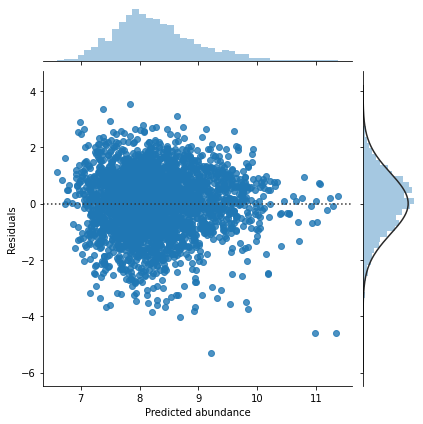

In [8]:
residuals_test = test_rescaled - predict_spombe

plot_data = pd.DataFrame()
plot_data['Residuals'] = residuals_test.ravel()
plot_data['Predicted abundance'] = predict_spombe.ravel()

sns.jointplot(y='Residuals', x='Predicted abundance', data=plot_data, kind="resid")

plt.savefig('figure07_4.svg', format='svg', dpi=600)

### Rescaled protein abundance

In [9]:
predict_spombe_expm1 = np.expm1(predict_spombe)
test_rescaled_expm1 = np.expm1(test_rescaled)

pearson = stats.pearsonr(test_rescaled_expm1.ravel(), predict_spombe_expm1.ravel())
spearman = stats.spearmanr(test_rescaled_expm1.ravel(), predict_spombe_expm1.ravel())

print('Pearson\'s r:', pearson[0], 'p-value:', pearson[1])
print('Spearman\'s r:', spearman[0], 'p-value:', spearman[1], '\n')

Pearson's r: 0.753368238578644 p-value: 0.0
Spearman's r: 0.7026983656906101 p-value: 0.0 



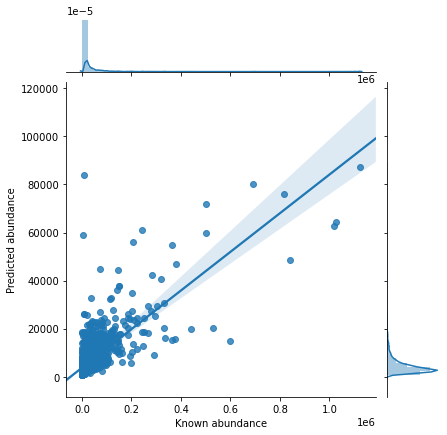

In [10]:
plot_data = pd.DataFrame()
plot_data['Known abundance'] = test_rescaled_expm1.ravel()
plot_data['Predicted abundance'] = predict_spombe_expm1.ravel()

#sns.jointplot(x='Known abundance', y='Predicted abundance', data=plot_data, kind="reg", xlim = {150000,0}, ylim = {150000,0})
sns.jointplot(x='Known abundance', y='Predicted abundance', data=plot_data, kind="reg")

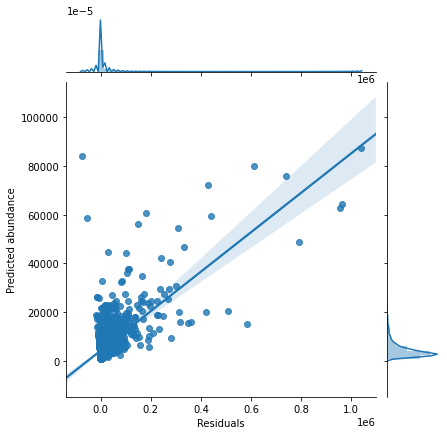

In [11]:
residuals_expm1 = test_rescaled_expm1 - predict_spombe_expm1

plot_data = pd.DataFrame()
plot_data['Residuals'] = residuals_expm1.ravel()
plot_data['Predicted abundance'] = predict_spombe_expm1.ravel()

sns.jointplot(x='Residuals', y='Predicted abundance', data=plot_data, kind="reg")